#Regressão Não Linear Múltipla 

##Instalar Pacotes Auxiliares

In [ ]:
!pip install pandas 'plotnine==0.8.0'
!pip install pyforest
!pip install dplython

##Importar Libs

**OBS Legenda**: Apenas informativa a respeito do que usaremos das libs nos exemplos. 

In [511]:
from pyforest import * #Principais Libs utilizadas no python (pandas, numpy,seaborn, matplotlib ...)
from plotnine import * #Utilização das principais funcionalidades do ggplot2 nativo do R no python
from dplython import * #Utilizado das principais funcionalidades do pacote nativo do R, dplyr no Python
from scipy.stats import norm #Criações de distribuições normais
from scipy.stats.distributions import chi2 #Cálculo do teste estátistico qui2
from sklearn.preprocessing import PowerTransformer #Transformações de box-cox 

import statsmodels.api as sm #Utilização de teste Anova
import statsmodels.formula.api as smf #Criação de modelos de regressão linear/não linear
import warnings #Retirar warnings de bibliotecas auxiliares
warnings.filterwarnings('ignore')

##Resumo da Base de Dados

**Objetivo**:

Identificar através dos dados coletados, quanto será gasto com despesas médicas para determinado cliente.

---

**Legenda Dados**:

- **id**: Código de Registro.
- **despmed**: Total das despesas médicas gastos em reais.
- **idade**: Idade atual do cliente.
- **dcron**: Quantidade de Doenças crônicas.
- **renda**: Renda anual do cliente em reais.
- **plano**: Modalidade do plano atual do cliente 
   * bronze
   * esmeralda	
   * ouro  

---

**Possíveis Variáveis para utilização no modelo**:

- **Preditoras**: idade, dcron, renda, plano.
- **Classe**: despmed.





###Importar Base de Dados

In [584]:
planoSaude=pd.read_csv('/content/drive/MyDrive/Dataset_Excel_CSV/planoSaude.csv')

<IPython.core.display.Javascript object>

Visualização dos primeiros dados

In [585]:
planoSaude.head()

,id,despmed,idade,dcron,renda,plano
0,1,206.84,57,5,57.200001,bronze
1,2,184.19,67,4,67.199997,bronze
2,3,175.68,62,4,62.000000,bronze
3,4,180.04,67,5,67.199997,bronze
4,5,218.86,68,5,68.000000,bronze


##Análise Exploratória

###Principais informações dos Tipos de Dados

In [514]:
planoSaude.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       200 non-null    int64  
 1   despmed  200 non-null    float64
 2   idade    200 non-null    int64  
 3   dcron    200 non-null    int64  
 4   renda    200 non-null    float64
 5   plano    200 non-null    object 
dtypes: float64(2), int64(3), object(1)
memory usage: 9.5+ KB


###Principais Estátisticas Descritivas Univariadas

In [515]:
planoSaude.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,200.0,100.5000,57.879185,1.00,50.75,100.500000,150.250000,200.0
despmed,200.0,161.1834,42.447084,88.73,126.14,155.000000,197.622500,269.2
idade,200.0,50.0100,12.547794,32.00,38.00,49.000000,63.000000,68.0
dcron,200.0,2.7050,1.670908,0.00,1.00,2.000000,4.000000,5.0
renda,200.0,50.0220,12.626538,31.60,38.00,48.799999,63.200001,68.0


###Tabela de Frequências da coluna Plano

Quantidade total de Cada plano.

In [516]:
pd.DataFrame(planoSaude['plano'].value_counts()).transpose()

<IPython.core.display.Javascript object>

,bronze,esmeralda,ouro
plano,72,66,62


###Correlações

* Verificar alta Multicolinearidade (Altas correlações entre variáveis preditoras, X).

* Verificar altas correlações com a variável classe.

<IPython.core.display.Javascript object>

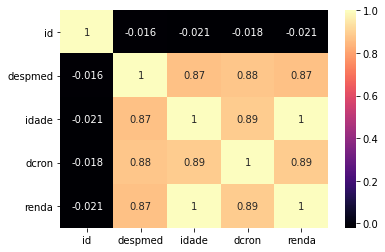

In [517]:
sns.heatmap(planoSaude.corr(),annot=True,cmap = 'magma');

##Preparação para o Modelo Linear Múltiplo

###Criação de N-1 Dummies

Para utilização de variáveis categóricas em modelos lineares, devemos primeiro transformar elas em dummies, ou seja, serão criadas novas colunas para indicar a presença ou ausência de cada categoria da variável.

Em regressões lineares, utilizarem o procedimento N-1 dummies, onde a categoria com mais frequência será retirada.   

In [518]:
planosaude_dummies=pd.get_dummies(planoSaude, columns=['plano'])
planosaude_dummies.drop('plano_bronze', axis = 1 ,inplace = True)
planosaude_dummies.head()

<IPython.core.display.Javascript object>

,id,despmed,idade,dcron,renda,plano_esmeralda,plano_ouro
0,1,206.84,57,5,57.200001,0,0
1,2,184.19,67,4,67.199997,0,0
2,3,175.68,62,4,62.000000,0,0
3,4,180.04,67,5,67.199997,0,0
4,5,218.86,68,5,68.000000,0,0


###Denifir Função para auxiliar à montagem de fórmulas

O modelo do statsmodel utiliza de formulas para representar como será realizada a previsão

Ex: y ~ x1 + x2

Criaremos uma função para remover as variáveis que não estarão contidas na fórmula. 
OBS: O último parâmetro opcional será utilizado para retornar o dataFrame filtrado ao invés da fórmula. Utilizaremos isso mais para frente

In [519]:
def montar_formula(df,colsRemover, y ,somenteColunas=False):
    colsRemover.append(y) #y nunca será utilizada em sua própria previsão
    if somenteColunas:
      return df[[col for col in df.columns if col not in colsRemover]]
    else:
      return y + ' ~ ' + ' + '.join([col for col in df.columns if col not in colsRemover])

Vamos demonstrar o uso da criação da fórmula e do retorno do DataFrame

In [520]:
montar_formula(planoSaude,['id'],'despmed')

'despmed ~ idade + dcron + renda + plano'

In [521]:
montar_formula(planoSaude,['id'],'despmed',True).head()

,idade,dcron,renda,plano
0,57,5,57.200001,bronze
1,67,4,67.199997,bronze
2,62,4,62.000000,bronze
3,67,5,67.199997,bronze
4,68,5,68.000000,bronze


###Criação de Modelo de Regressão Linear Múltipla

Utilizando a mesma formula acima, criaremos o modelo

In [522]:
formula = montar_formula(planosaude_dummies, ['id'], 'despmed')
modelo_planoSaude = smf.ols(formula = formula, data = planosaude_dummies).fit()

Vamos verificar também seus parâmetros

In [523]:
print(modelo_planoSaude.summary())

                            OLS Regression Results                            
Dep. Variable:                despmed   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     262.3
Date:                Wed, 18 Aug 2021   Prob (F-statistic):           2.88e-84
Time:                        18:34:57   Log-Likelihood:                -828.04
No. Observations:                 200   AIC:                             1668.
Df Residuals:                     194   BIC:                             1688.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         148.8596     12.744     

Vejamos alguns parâmetros: 

Obs: Estamos utilizando para esse exemplo o padrão de um nível de significância de 0.05 (5%) num intervalo de confiança de 95%.

* R-squared: Indica quanto da variação da nossa y é explicada por um modelo linear. Nesse caso 87.%

* Prob (F-statistic): : Indica a significância geral da regressão num teste f. Quanto mais próximas de zero, e menores que nosso nível de significância indicam geralmente que nossa regressão é significativa em pelo menos uma das variáveis utilizadas.

* P>|t|: Indica a significância de cada variável num teste t. Quanto mais próxima de zero, e menor que nosso nível de significância indica que a variável é importante nesse atual modelo múltiplo criado.

###Interpretação um pouco mais Aprofundada dos Resultados

Conforme visto acima, a idade e a renda parecem não serem importantes para **esse modelo** mesmo tendo altas correlações com nossa variável classe. vamos realizar uma regressão linear simples de cada uma dessas variável com nossa classe.

In [524]:
modelo_renda = smf.ols(formula = 'y ~ renda', data = planoSaude).fit()
print(modelo_renda.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     590.7
Date:                Wed, 18 Aug 2021   Prob (F-statistic):           2.47e-61
Time:                        18:34:57   Log-Likelihood:                -894.73
No. Observations:                 200   AIC:                             1793.
Df Residuals:                     198   BIC:                             1800.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.6543      6.175      2.535      0.0

In [525]:
modelo_idade = smf.ols(formula = 'y ~ idade', data = planoSaude).fit()
print(modelo_idade.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     601.0
Date:                Wed, 18 Aug 2021   Prob (F-statistic):           6.82e-62
Time:                        18:34:57   Log-Likelihood:                -893.43
No. Observations:                 200   AIC:                             1791.
Df Residuals:                     198   BIC:                             1797.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     14.4604      6.170      2.344      0.0

Interessante, veja que ambos os testes passam em todos os parâmetros observados anteriormente. Isso pode indicar que alguma de nossas outras variáveis utilizadas (dcron ou as dummies do plano) estão capturando essa variabilidade presente tanto na renda quanto na idade, sendo assim não tão relevantes **naquele** modelo múltiplo. Vamos então melhorar nosso modelo com uma técnica muita utilizada: **Stepwise**

##Stepwise

A regressão stepwise é a construção iterativa passo a passo de um modelo de regressão que envolve a seleção de variáveis ​​independentes a serem usadas em um modelo final. Envolve adicionar ou remover variáveis ​​explicativas potenciais em sucessão e testar a significância estatística após cada iteração.

###Separar variáveis preditoras e classe

Serpararemos primeiro as variáveis preditoras da classe em outras X e y para realização do teste 

In [526]:
X = montar_formula(planosaude_dummies, ['id'], 'despmed', True)
y = planosaude_dummies['despmed']

###Definir função para realização do stepwise

Para realização desse filtro, devemos buscar as melhores variáveis preditoras. Nesse caso criei um função que filtrará baseado nos melhores p-values em relação ao nosso nível de significância durante iterativas passagens.

In [527]:
def step(X, y,significancia=0.05):
    lista_inicial = []
    incluidos = list(lista_inicial)
    while True:
        modificado=False
        excluidos = list(set(X.columns) - set(incluidos))
        novo_pvalue = pd.Series(index = excluidos, dtype='float32')
        for nova_coluna in excluidos:
            modelo = sm.OLS(y, sm.add_constant(pd.DataFrame(X[incluidos + [nova_coluna]]))).fit()
            novo_pvalue[nova_coluna] = modelo.pvalues[nova_coluna]
        melhor_pvalue = novo_pvalue.min()
        if melhor_pvalue < significancia:
            melhor_caracteristica = novo_pvalue.idxmin()
            incluidos.append(melhor_caracteristica)
            modificado=True            

        if not modificado:
            break

    return incluidos

Vejamos o resultado obtido

In [528]:
step(X,y)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

['dcron', 'plano_ouro', 'plano_esmeralda']

Veja que a idade e renda foram realmente retiradas de nosso modelo. Prosseguiremos em seguida criando um novo modelo com base nessa análise.

##Criação de Modelo de Regressão Linear Múltipla com Stepwise

Novamente criaremos um modelo, porém agora excluindo a idade e a renda do mesmo

In [529]:
formula = montar_formula(planosaude_dummies, ['id', 'renda', 'idade'], 'despmed')
step_planoSaude = smf.ols(formula = formula, data = planosaude_dummies).fit()

print(step_planoSaude.summary())

                            OLS Regression Results                            
Dep. Variable:                despmed   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     429.1
Date:                Wed, 18 Aug 2021   Prob (F-statistic):           7.53e-86
Time:                        18:34:57   Log-Likelihood:                -830.54
No. Observations:                 200   AIC:                             1669.
Df Residuals:                     196   BIC:                             1682.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         170.4948      6.345     

* Parece um pouco melhor, visto que agora todas as probabilidades atendem ao critério prop < p_value. 

* OBS: Naturalmente, ao adicionar novas variáveis o R-squared tenderá a aumentar, nesse caso é normal ele ter diminuido visto que retiramos a idade e renda do conjunto.

* Finalizamos? Ainda Não.

  * Devemos além disso verificar se a distribuição de probabilidade de nossos resíduos (y verdadeiros - y previstos) é semelhante a uma distribuição normal.

##Verificar Aderência dos resíduos à normalidade (Teste de Shapiro-Francia)

###Definir Função de Ordenadas para Plotagem de Probabilidade

Primeiramente vamos definir uma função para gerar a sequência de pontos de probabilidade

In [530]:
def ppoints(n, a):   
    try:
        n = np.float(len(n))
    except TypeError:
        n = np.float(n)
    return (np.arange(n) + 1 - a)/(n + 1 - 2*a)

###Definir Função Para Remover as Diagonais Principais (iguais à 1)

Vamos também criar uma função para remover as diagonais principais dos parâmetros W e pval que serão calculados

In [531]:
def removerDiagonal(x):
    x_sem_diagonais = np.ndarray.flatten(x)
    x_sem_diagonais = np.delete(x_sem_diagonais, range(0, len(x_sem_diagonais), len(x) + 1), 0)
    x_sem_diagonais = x_sem_diagonais.reshape(len(x), len(x) - 1)
    return x_sem_diagonais

###Definir função para cálculo do teste de Shapiro Francia

* O Python não tem (que eu conheça) um pacote para o cálculo do Shapiro Francia 
que é um teste estatístico para a normalidade de uma população, 
baseado em dados amostrais. É uma simplificação do teste de Shapiro-Wilk, que apesar de pouco conhecido, é um do mais confiáveis testes estátisticos para  amostras com mais de 30 observações. 

* Veja mais detalhes dele na [Wikipedia](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Francia_test).



---



* Para que o modelo criado seja realmente o final, devemos avaliar se ele atende ao critério de normalidade com um p-value > 0.05 para aceitarmos a hipótese alternativa (H1).

 > H0: Os resíduos têm distribuição normal.

 > H1: Os resíduos não têm distribuição normal.


* Abaixo crio uma pequena função com sua implementação no Python.

In [532]:
def shapiroFrancia(x):
  x = np.sort(x)
  n = len(x)
  y = norm.ppf(ppoints(n,a = 3/8))
  W = np.corrcoef(x, y)**2
  u = np.log(n)
  v = np.log(u)
  mu = -1.2725 + 1.0521 * (v - u)
  sig = 1.0308 - 0.26758 * (v + 2/u)
  z = (np.log(1 - W) - mu)/sig
  pval = norm.sf(z)
  print('W: {}'.format(removerDiagonal(W)[0][0]))
  print('p-value: {}'.format(removerDiagonal(pval)[0][0]))

###Verificando a normalidade dos resíduos do modelo

In [533]:
shapiroFrancia(step_planoSaude.resid)

W: 0.9429167651264184
p-value: 2.017345699616918e-06


Veja que nosso p-value não ficou acima de 0.05 o que indica que teremos problemas com esse modelo, visto que ele apesar de ser linear, não se dá de forma normal.

###Plotando os resíduos do modelo stepwise

Vejamos como a distribuição desses resíduos está agora por meio de um gráfico

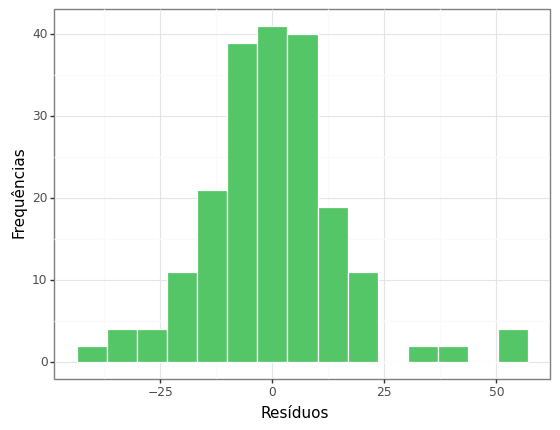

<ggplot: (8739784480681)>

In [534]:
(ggplot(planoSaude >>
  mutate(residuos = step_planoSaude.resid),
        aes(x='residuos')) +
    geom_histogram(color = "white", 
                   fill = "#55C667FF", 
                   bins = 15,
                   alpha = 0.6) +
    labs(x = "Resíduos",
         y = "Frequências") + 
    theme_bw())

Vamos acrescentar uma curva normal para melhor comparar as distribuições

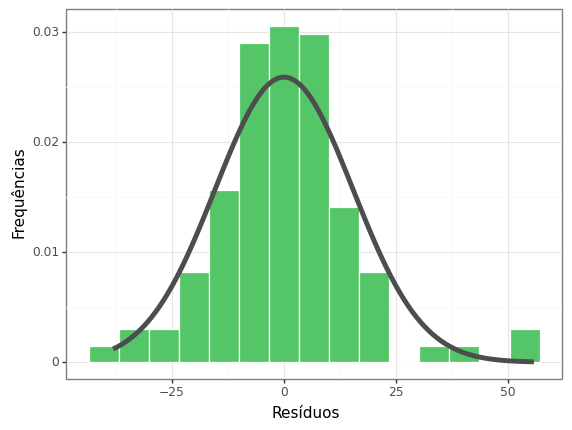

<ggplot: (8739784461217)>

In [535]:
(ggplot(planosaude_dummies >>
  mutate(residuos = step_planoSaude.resid),
        aes(x='residuos')) +
    geom_histogram(aes(y ='..density..'),
                   color = "white", 
                   fill = "#55C667FF", 
                   bins = 15,
                   alpha = 0.6) +
     stat_function(fun=norm.pdf,
                   args={'loc':np.mean(step_planoSaude.resid),
                         'scale':np.std(step_planoSaude.resid)},
                size = 2, color = "#4d4d4d") +
     scale_color_manual(values = "#7f7f7f") +
    labs(x = "Resíduos",
         y = "Frequências") + 
    theme_bw())

Outra forma de vermos é via um gráfico de estimativa de densidade de kernel ( KDE) que é uma forma não paramétrica de estimar a função de densidade de probabilidade de uma variável aleatória.

As estimativas de densidade do kernel estão muito relacionadas aos histogramas convencionais, mas são sensíveis à propriedades o que permite melhor visualização da suavidade ou continuidade dos dados.

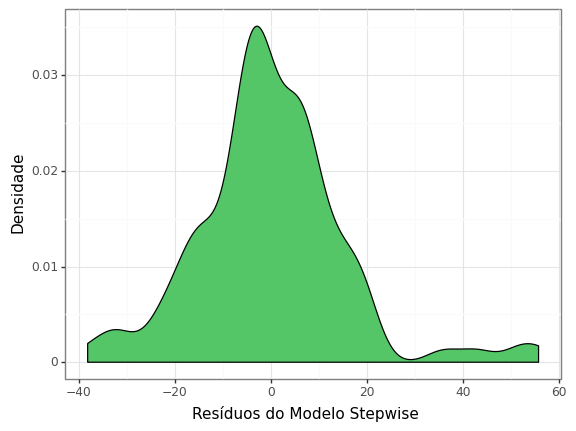

<ggplot: (8739784401237)>

In [536]:
(planosaude_dummies >>
  ggplot() +
  geom_density(aes(x = step_planoSaude.resid), fill = "#55C667FF") +
  labs(x = "Resíduos do Modelo Stepwise",
       y = "Densidade") +
  theme_bw())

##Diagnóstico de Heterocedasticidade

Desejamos que a variância dos resíduos gerados pelo modelo seja sempre constante. Se isso acontecer, temos a  homocedasticidade, caso contrário, quando a variância dos resíduos não é constante, ocorre a heterocedasticidade.

A presença de heterocedasticidade no modelo gera parâmetros não eficientes, acarretando erro em todas as análises.

Isso se dá geralmente quando alguma variável preditora importante está ausente no modelo, e que serviria para ajudar à explicar o mesmo.

###Realização do Teste de Breusch-Pagan

Para verificar se nosso modelo atende a esse critério, testaremos se a variância dos erros é dependente dos valores das variáveis ​​independentes. Nesse caso, a heteroscedasticidade está presente.

> H0: ausência de heterocedasticidade.

> H1: heterocedasticidade, ou seja, correlação entre resíduos e uma ou mais
variáveis explicativas, o que indica omissão de alguma variável importante.

Abaixo temos o passo à passo para realização do cálculo do teste de Breusch Pagan.

####Prever resultados utilizando a base de dados original

In [537]:
yhat = step_planoSaude.predict(exog=planosaude_dummies[['dcron', 'plano_ouro', 'plano_esmeralda']])

####Calcular os resíduos (Diferença do y verdadeiro com o previsto)

In [538]:
residuos = planosaude_dummies['despmed'] - yhat

####Calcular erro Up

In [539]:
up = ((residuos) ** 2) / ((sum(residuos**2)) / len(residuos))

####Criar DataFrame para utilizar no modelo

In [540]:
dados_breuschpagan=pd.DataFrame({'up': up, 'yhat': yhat})

<IPython.core.display.Javascript object>

####Criar Modelo

In [541]:
modelo_breuschpagan = smf.ols(formula='up ~ yhat',data=dados_breuschpagan).fit()

####Criação de Função para Soma dos Quadrados

In [542]:
def SomaQuadrados(x):
  soma_quadrados = sum([valor ** 2 for valor in x])
  return soma_quadrados - (x.sum()**2) / len(x)

In [543]:
SomaQuadrados(modelo_breuschpagan.fittedvalues)

121.60364988470738

####Comparação com Resultado da Anova

In [544]:
sm.stats.anova_lm(modelo_breuschpagan, typ=2) #ANOVA DataFrame

,sum_sq,df,F,PR(>F)
yhat,121.603650,1.0,32.335908,4.602923e-08
Residual,744.606349,198.0,NaN,NaN


####Verificar Resultados do Teste

In [545]:
print('df: {}'.format(1))
print('chi2: {}'.format(121.603650	/2))
print('p-value {}'.format(chi2.sf(121.603650/2,1)))

df: 1
chi2: 60.801825
p-value 6.3119380573521175e-15


Veja que no teste, o p-value ficou abaixo de 0.05, o que faz que exista a presença de heterocedasticidade no modelo previsto.

###Gráfico que relaciona os resíduos e os fitted values do modelo

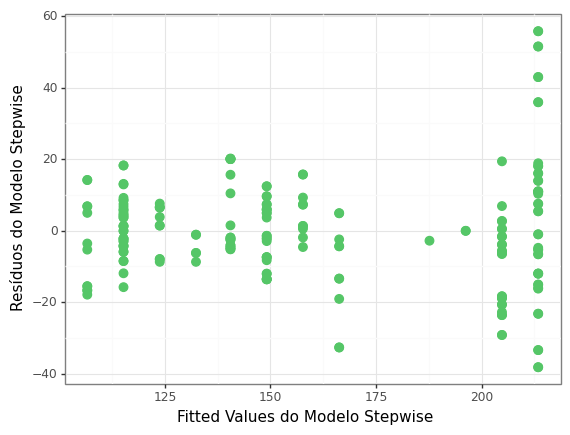

<ggplot: (8739784342293)>

In [546]:
(ggplot(planosaude_dummies >>
  mutate(fittedvalues = step_planoSaude.fittedvalues,residuos=step_planoSaude.resid),
        aes(x='fittedvalues',y='residuos')) +
 geom_point(color = "#55C667FF", size = 3) +
  labs(x = "Fitted Values do Modelo Stepwise",
       y = "Resíduos do Modelo Stepwise") +
  theme_bw())

Veja as relações entre os resíduos (erros) e os fitted Values.

##Transformação de Box-Cox

Quando os dados disponíveis afastam-se de uma distribuição normal, um dos caminhos é fazer a transformação dos dados por box-cox.

Essa transformação é bastante conhecida no meio econométrico e usada para enfrentar problemas de heterocedasticidade.

No nosso exemplo seu principal objetivo será o de escolher o melhor valor de lambda para a transformação da nossa variável classe. Conforme imagem abaixo:

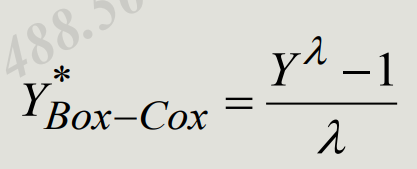

###Calcular o lambda de Box-Cox

Utilizaremos a função PowerTransformer de forma não padronizada para encontrar o valor

In [547]:
pt = PowerTransformer(method='box-cox', standardize=False)
pt.fit(planoSaude['despmed'].values.reshape(-1, 1))

PowerTransformer(copy=True, method='box-cox', standardize=False)

In [548]:
lambda_bc=pt.lambdas_
lambda_bc

array([-0.14436742])

###Inserir o lambda de Box-Cox na base de dados

Com o valor de lambda encontrado, maximizaremos à aderência da distribuição da nova variável y à normalidade. Esse valor ficará contido em outra variável, despesas médica box-cox (bcdespmed) 

In [561]:
planosaude_dummies['bcdespmed'] = (((planoSaude['despmed'] ** lambda_bc) - 1) / lambda_bc)

###Visualizando a nova variável na base de dados

In [563]:
planosaude_dummies[['id','despmed','bcdespmed']].head()

,id,despmed,bcdespmed
0,1,206.84,3.718813
1,2,184.19,3.664649
2,3,175.68,3.642295
3,4,180.04,3.653899
4,5,218.86,3.744867


##Estimando Novo Modelo Múltiplo Não Linear

Vamos estimar novamente nosso modelo.

**OBS:** Veja que adicionamos novamente nossas variáveis idade e renda, visto que por ser um novo modelo poderá ou não conter essas variáveis.

In [568]:
formula = montar_formula(planosaude_dummies, ['despmed', 'id'], 'bcdespmed')
modelo_planoSaude_bc = smf.ols(formula=formula,data = planosaude_dummies).fit()

print(modelo_planoSaude_bc.summary())

                            OLS Regression Results                            
Dep. Variable:              bcdespmed   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     325.5
Date:                Wed, 18 Aug 2021   Prob (F-statistic):           2.80e-92
Time:                        18:56:49   Log-Likelihood:                 355.33
No. Observations:                 200   AIC:                            -698.7
Df Residuals:                     194   BIC:                            -678.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.5507      0.034    1

Ao que parece, essas variáveis novamente não se encaixam no modelo. 
Vamos validar isso com o procedimento stepwise, porém agora com box-cox.

###Aplicando o procedimento Stepwise

Vamos separar nossas variáveis e rodar o método stepwise novamente.

In [553]:
X = montar_formula(planosaude_dummies, ['despmed','id'], 'bcdespmed', True)
y = planosaude_dummies['bcdespmed']
step(X,y)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

['dcron', 'plano_ouro', 'plano_esmeralda']

Concluímos então que não usaremos essas variáveis nesse novo modelo. Vamos criar esse novo modelo abaixo.

##Finalizando Modelo Múltiplo Não Linear com Stepwise

In [570]:
formula = montar_formula(planosaude_dummies, ['despmed','id','renda','idade'],'bcdespmed')
step_planoSaude_bc = smf.ols(formula = formula, data = planosaude_dummies).fit()

print(step_planoSaude_bc.summary())

                            OLS Regression Results                            
Dep. Variable:              bcdespmed   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     539.4
Date:                Wed, 18 Aug 2021   Prob (F-statistic):           2.07e-94
Time:                        19:03:52   Log-Likelihood:                 353.90
No. Observations:                 200   AIC:                            -699.8
Df Residuals:                     196   BIC:                            -686.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.5983      0.017    2

Parece que tudo está certo. Vamos agora validar os testes estátisticos de normalidade e heterocedasticidade.

###Verificando a normalidade dos resíduos do modelo 

In [571]:
shapiroFrancia(step_planoSaude_bc.resid)

W: 0.9868895949417092
p-value: 0.05846186724841663


Ficou bem em cima! Mas o teste comprova que essa distribuição à um nível de significância 0.05 é normal. 

###Plotando os novos resíduos do modelo

Vejamos como fica com o gráfico com a curva normal

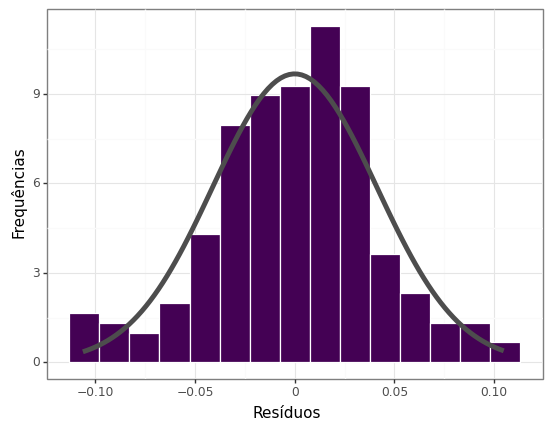

<ggplot: (8739784291137)>

In [556]:
(ggplot(planosaude_dummies >>
  mutate(residuos = step_planoSaude_bc.resid),
        aes(x='residuos')) +
    geom_histogram(aes(y ='..density..'),
                   color = "white", 
                   fill = "#440154FF", 
                   bins = 15,
                   alpha = 0.6) +
     stat_function(fun=norm.pdf,
                   args={'loc':np.mean(step_planoSaude_bc.resid),
                         'scale':np.std(step_planoSaude_bc.resid)},
                size = 2, color = "#4d4d4d") +
     scale_color_manual(values = "#7f7f7f") +
    labs(x = "Resíduos",
         y = "Frequências") + 
    theme_bw())

Podemos ver também como fica com o KDE

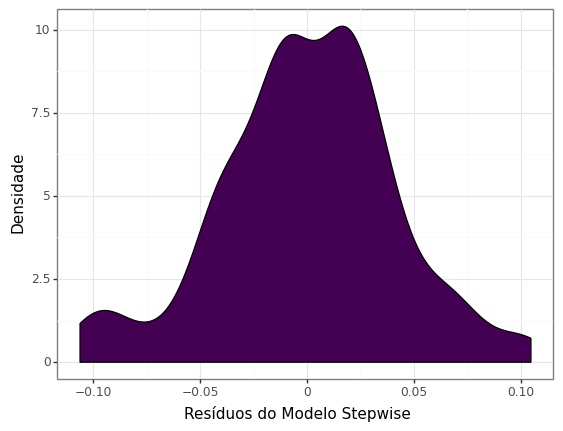

<ggplot: (8739785843653)>

In [572]:
(planosaude_dummies >>
  ggplot() +
  geom_density(aes(x = step_planoSaude_bc.resid), fill = "#440154FF") +
  labs(x = "Resíduos do Modelo Stepwise",
       y = "Densidade") +
  theme_bw())

###Definição de função para cálculo do teste de breusch pagan

Para simplificar o cálculo, vamos criar uma função para simplificar o teste de Breusch Pagan

In [558]:
def olsBreuschPagan(df,cols,y,model):
  yhat = model.predict(exog=df[cols])
  residuos = df[y] - yhat
  up = ((residuos) ** 2) / ((sum(residuos ** 2)) / len(residuos))
  dados_breuschpagan = pd.DataFrame({'up': up,'yhat': yhat})
  modelo_breuschpagan = smf.ols(formula='up ~ yhat',data = dados_breuschpagan).fit()
  soma_quadrados = SomaQuadrados(modelo_breuschpagan.fittedvalues)
  print('df: {}'.format(1))
  print('chi2: {}'.format(soma_quadrados / 2))
  print('p-value {}'.format(chi2.sf(soma_quadrados / 2,1)))

###Diagnóstico de Heterocedasticidade para o Modelo Stepwise com Box-Cox

In [573]:
olsBreuschPagan(planosaude_dummies, ['dcron', 'plano_ouro', 'plano_esmeralda'],'bcdespmed', step_planoSaude_bc)

<IPython.core.display.Javascript object>

df: 1
chi2: 1.0126281112242879
p-value 0.31427404714875107


Perfeito, o teste comprova a homocedasticidade nos nossos dados.

Podemos ver essa pequena, mas importante diferença plotando e vendo como ficou a relação entre os resíduos e os fittedvalues.

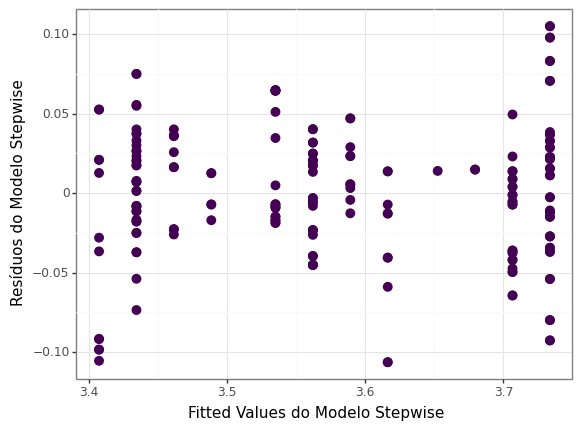

<ggplot: (8739784239005)>

In [560]:
(ggplot(planosaude_dummies >>
  mutate(fittedvalues = step_planoSaude_bc.fittedvalues,residuos=step_planoSaude_bc.resid),
        aes(x='fittedvalues',y='residuos')) +
 geom_point(color = "#440154FF", size = 3) +
  labs(x = "Fitted Values do Modelo Stepwise",
       y = "Resíduos do Modelo Stepwise") +
  theme_bw())

##Comparação do R² Ajustado dos Modelos

O R² ajustado indica quão bem os termos se ajustam a uma curva ou linha e para o número de termos em um modelo. Se você adicionar mais e mais variáveis inúteis a um modelo, o r² ajustado diminuirá. Se você adicionar mais variáveis úteis , o r² ajustado aumentará. O R² ajustado será sempre menor ou igual ao R². Devido à sua natureza, é possível comparar diferentes tipos de modelos (linear e não linear).

In [576]:
pd.DataFrame({'R² Ajustado Modelo Linear': modelo_planoSaude.rsquared_adj,
              'R² Ajustado Modelo Não Linear': modelo_planoSaude_bc.rsquared_adj}
             ,index=[0])

<IPython.core.display.Javascript object>

,R² Ajustado Modelo Linear,R² Ajustado Modelo Não Linear
0,0.867814,0.89075


Veja que tivemos um ganho no R² ajustado no modelo de box-cox, o que indica realmente a captura maior da variabilidade. 

##Plotando Despesas Médicas em função das doenças crônicas, com destaque para os planos de saúde

Para finalizarmos, podemos ver abaixo de forma simplificada, outra forma de visualizar como cada plano de saúde está diretamente relacionado à doença crônica e a despesa médica de cada cliente.

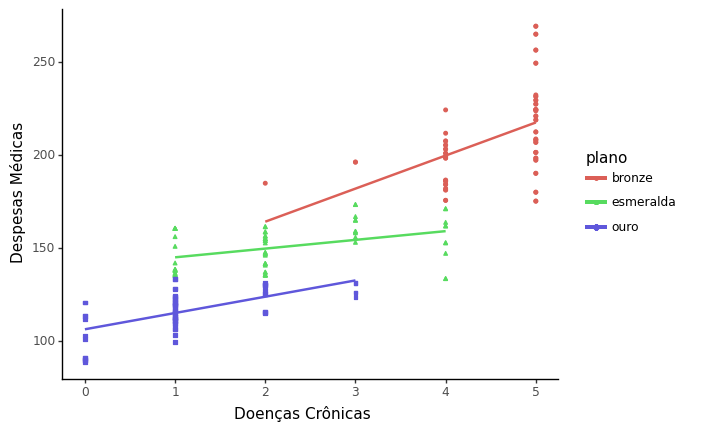

<ggplot: (8739784663693)>

In [583]:
(ggplot(planoSaude, 
        aes(x ='dcron', y = 'despmed', color = 'plano', shape = 'plano')) +
          geom_point(size = 1) +
          geom_smooth(method = "lm", se = False) +
          xlab("Doenças Crônicas") +
          ylab("Despesas Médicas") +    
          theme_classic())